In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import pandas as pd
from ic.eval_ import present_df
import matplotlib.pyplot as plt
import numpy as np
import torch

In [23]:
!ls -tl out/results/ | head -n 5

total 497645
-rw-r----- 1 mathias mathias 614498680 Mar 22 17:39 batik_eval.h5
-rw-r----- 1 mathias mathias 188036640 Mar 10 12:38 result.h5
-rw-r----- 1 mathias mathias   8038304 Feb 19 17:29 result_ics.h5
-rw-r----- 1 mathias mathias   1137112 Jan  5 14:47 weight.h5


In [24]:
result_file = 'out/results/batik_eval.h5'
# result_file = 'out/results/weight.h5'
ex = pd.read_hdf(result_file, 'ex')
int_df = pd.read_hdf(result_file, 'int_df')
tok_df = pd.read_hdf(result_file, 'tok_df')
piece_df = pd.read_hdf(result_file, 'piece_df')

Text(0.5, 1.0, 'Padding distribution')

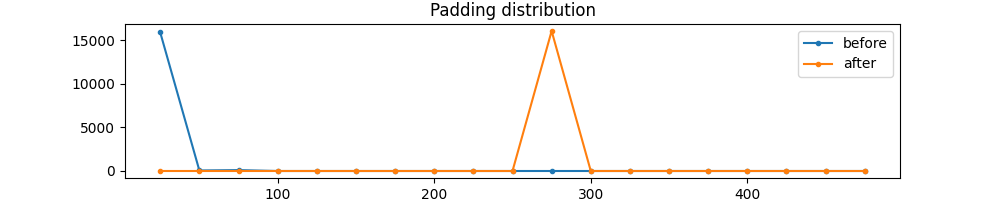

In [25]:
fig, ax = plt.subplots(figsize=(10, 2))
edges = np.arange(0, 500 , 25)
hist_before, _ = np.histogram(piece_df.pad_before, bins=edges)
hist_after, _ = np.histogram(piece_df.pad_after, bins=edges)
ax.plot(edges[1:], hist_before, '.-', label='before')
ax.plot(edges[1:], hist_after, '.-', label='after')
ax.legend()
ax.set_title('Padding distribution')

In [4]:
merged_pieces = piece_df.merge(ex, right_index=True, left_on = 'ids')

In [32]:
merged_pieces.n_inpaint.max()

183

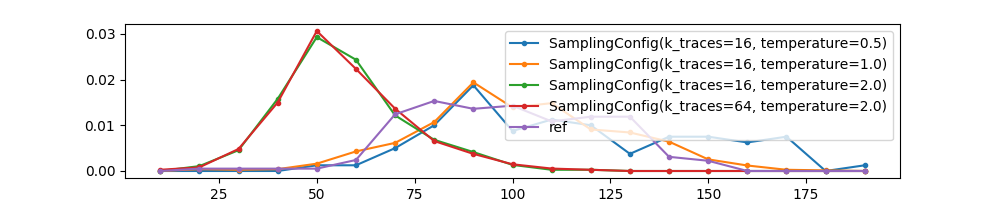

In [43]:
edges = np.arange(0, 200 , 10)
fig, ax = plt.subplots(figsize=(10, 2))
for (exp, sample_conf), g_df in merged_pieces.groupby(['exps', 'params']):
    hist, _ = np.histogram(g_df.n_inpaint, bins=edges, density=True)
    ax.plot(edges[1:], hist, '.-', label=f'{sample_conf}')
ax.legend()

In [29]:
ex.groupby('params').groups.keys()

dict_keys(['SamplingConfig(k_traces=16, temperature=0.5)', 'SamplingConfig(k_traces=16, temperature=1.0)', 'ref'])

In [25]:
present_df(ex, int_df, tok_df)

                                                                                                ic_dev  \
                                                                                                  mean   
exps                                               params                                                
Experiment(time_points_generator=FixedStepTimep... SamplingConfig(k_traces=16, temperature=0.5)  6.057   
                                                   SamplingConfig(k_traces=16, temperature=1.0)  0.011   

                                                                                                          \
                                                                                                abs_mean   
exps                                               params                                                  
Experiment(time_points_generator=FixedStepTimep... SamplingConfig(k_traces=16, temperature=0.5)    8.014   
                                     

In [5]:
tok_merged = ex.merge(tok_df, left_index=True, right_on="ids",how='outer')
tok_merged.columns

Index(['exps', 'params', 'piece', 'sample', 'ids', 'time', 'ic_pitch',
       'ic_vel', 'ic_dur', 'ic_shift', 'ic_mean'],
      dtype='object')

,exps,params,piece,sample,ids,time,ic_pitch,ic_vel,ic_dur,ic_shift,ic_mean
0,Experiment(time_points_generator=FixedStepTime...,ref,326,ref,0,28.540001,0.266787,2.343239,2.825327,NaN,1.811784
1,Experiment(time_points_generator=FixedStepTime...,ref,326,ref,0,28.640001,0.280676,3.215013,1.047859,0.739824,1.320843
2,Experiment(time_points_generator=FixedStepTime...,ref,326,ref,0,28.760000,0.904482,2.943955,1.377741,1.266184,1.623091
3,Experiment(time_points_generator=FixedStepTime...,ref,326,ref,0,28.880001,0.015330,4.368188,1.180279,2.215304,1.944775
4,Experiment(time_points_generator=FixedStepTime...,ref,326,ref,0,28.960001,0.021252,3.340963,1.548885,2.028958,1.735015
...,...,...,...,...,...,...,...,...,...,...,...
1650576,Experiment(time_points_generator=FixedStepTime...,"SamplingConfig(k_traces=128, temperature=1.0, ...",417,2,16595,37.719997,0.944181,2.218397,0.076515,0.001863,0.810239
1650577,Experiment(time_points_generator=FixedStepTime...,"SamplingConfig(k_traces=128, temperature=1.0, ...",417,2,16595,37.719997,0.349567,3.707844,0.063097,0.000248,1.030189
1650578,Experiment(time_points_generator=FixedStepTime...,"SamplingConfig(k_traces=128, temperature=1.0, ...",417,2,16595,37.719997,0.182400,1.991039,0.098342,0.005291,0.569268
1650579,Experiment(time_points_generator=FixedStepTime...,"SamplingConfig(k_traces=128, temperature=1.0, ...",417,2,16595,38.639999,NaN,NaN,NaN,2.546483,2.546483


### Calculate the mean IC to be used for normalizing the ICs

In [57]:
normalizer = 1/tok_merged[tok_merged.params == 'ref'].agg({'ic_pitch': 'mean', 'ic_vel': 'mean', 'ic_dur': 'mean', 'ic_shift': 'mean'})
normalizer

ic_pitch    1.141951
ic_vel      0.312471
ic_dur      0.332826
ic_shift    0.511330
dtype: float64

In [59]:
tok_merged_normed = tok_merged.copy()
tok_merged_normed[['ic_pitch', 'ic_vel', 'ic_dur', 'ic_shift']] = tok_merged[['ic_pitch', 'ic_vel', 'ic_dur', 'ic_shift']] * normalizer.values

In [61]:
tok_merged.groupby('params').agg({'ic_pitch': 'mean', 'ic_vel': 'mean', 'ic_dur': 'mean', 'ic_shift': 'mean'})

,ic_pitch,ic_vel,ic_dur,ic_shift
params,,,,
"SamplingConfig(k_traces=16, temperature=1.0)",1.193759,2.885858,2.627582,1.714499
ref,0.875694,3.200298,3.004571,1.955684


In [62]:
tok_merged_normed.groupby('params').agg({'ic_pitch': 'mean', 'ic_vel': 'mean', 'ic_dur': 'mean', 'ic_shift': 'mean'})

,ic_pitch,ic_vel,ic_dur,ic_shift
params,,,,
"SamplingConfig(k_traces=16, temperature=1.0)",1.363214,0.901747,0.874528,0.876675
ref,1.000000,1.000000,1.000000,1.000000


In [36]:
for i in ['temp'] + list(range(4)):
    file = f'out/experiment-time-points-generator-fixedsteptimepoints-step-0-5-weight-movingaverage-window-size-0-5-c-1-0-channel-weight-1-07-0-3-0-45-0-73-dataset-datapiece-batik-ic-curve-none-match-metric-ic/samplingconfig-k-traces-16-temperature-1-0/kv332_2_start_149_nodes_177/{i}/ic.pt'
    print(i, (torch.load(file).ic_tok * normalizer.values).mean(0).tolist())

temp [0.9381523099671922, 0.9733174237153968, 1.353154444354705, 1.4300356222852666]
0 [0.9957575399633618, 0.8446423510521419, 1.0394252040011718, 1.2409117388830726]
1 [1.2600783701223501, 0.8603173659492088, 1.134012008038527, 1.136829680510853]
2 [1.2118009863334855, 0.8583741322637384, 1.2935531969189695, 1.1860657703700246]
3 [1.641407599530527, 0.9472145251321012, 1.2341045549989191, 1.4509081765701826]


In [9]:
# tok_10s = tok_merged[tok_merged.exps=="Experiment(time_points_generator=FixedStepTimepoints(step=0.5), weight=MovingAverage(window_size=0.5, c=1.0), dataset=DataCache(label='validation', n_inpaint=10.0, n_pieces=200), ic_curve=None)"]
time_inpaint =tok_merged.groupby('piece').agg({'time' : 'max'})
time_inpaint.agg({'time' : ['min', 'mean', 'max']})

,time
min,9.780000
mean,9.896666
max,10.000000


In [10]:
time_inpaint.hist()

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

In [21]:
tok_df.shape, merged.shape

((558327, 7), (558327, 11))

In [5]:
time_inpaint = merged[merged.params == 'ref'].groupby('piece').agg({'time' : 'max'})
time_inpaint.agg({'time' : ['min', 'mean', 'max']})

,time
min,4.180000
mean,13.538051
max,52.060001


array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

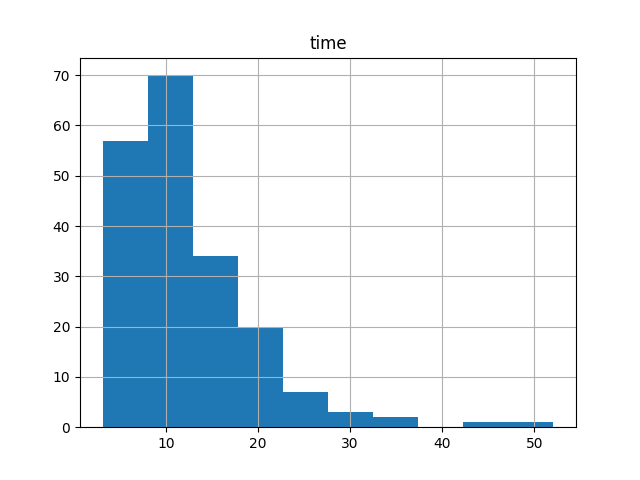

In [35]:
# fig, ax = plt.subplots()
time_inpaint.hist()

# Interpolations exps

In [33]:
merged = ex.merge(int_df, left_index=True, right_on="ids",how='outer')
res_int = merged[merged['params'] != 'ref'].groupby(['exps', 'params']).agg({'ic_dev': ['mean', ('abs_mean', lambda x: x.abs().mean()), 'std', 'count']})

In [34]:
# NOTE: find the minimum index of 
abs_min = res_int.loc[:, [('ic_dev', 'abs_mean')]]
abs_min.min().item(), abs_min.idxmin().item()


(1.2180415977900374,
 ('{"time_points_generator": {"step": 0.5, "eval_step": 0.1, "k_traces": 128, "tol_placeholder_duration": 0.2}, "weight": {"window_size": 2.0, "channel_weight": [0.90991811, 0.0, 0.0, 0.68306011]}, "dataset": {"label": "batik", "n_inpaint": 10.00001, "split": "validation", "midi_path": "/share/hel/home/mathias/datasets/batik_plays_mozart", "cache_path": "/share/hel/home/mathias/.cache/mutdata/pia", "n_pieces": 150, "end_window": 0}, "ic_curve": null, "match_metric": "ic", "metric_clip": null, "onset_on_next_note": true, "reduce_equal_times": "sum"}',
  '{"k_traces": 128, "temperature": 1.0, "n_poly_notes": null, "dynamic_temperature_max_ic": null, "top_p": 0.0, "top_k": 0}'))

In [35]:
import json
from typing import Callable
from functools import partial
def apply_pd(x: pd.Series, filter_fun: Callable[[dict, dict], bool]):
    exp_json, params_json = x.name
    parms = json.loads(params_json)
    exp = json.loads(exp_json)
    return filter_fun(parms, exp)

def filter_pd(df, filter_fun: Callable[[dict, dict], bool]) -> pd.DataFrame:
    return df[df.apply(partial(apply_pd, filter_fun=filter_fun), axis=1)]
def filter_temp(parms : dict, exp : dict):
    return parms['dynamic_temperature_max_ic'] != None or parms['dynamic_temperature_max_ic'] == None and parms['k_traces']  == 16 and exp["time_points_generator"]["step"] == 0.5
def filter_k_traces(params : dict, exp : dict):
    return params['k_traces']  != 16 or params['dynamic_temperature_max_ic'] == None and params['k_traces']  == 16 and exp["time_points_generator"]["step"] == 0.5
def filter_steps(params : dict, exp : dict):
    return exp["time_points_generator"]["step"] != 0.5 or params['dynamic_temperature_max_ic'] == None and params['k_traces']  == 16 and exp["time_points_generator"]["step"] == 0.5


In [36]:
filtered = filter_pd(res_int, filter_temp)
abs_div = filtered.loc[:, [('ic_dev', 'abs_mean')]]
print(abs_div.min().item(), abs_div.idxmin().item())
filtered

1.84580943674408 ('{"time_points_generator": {"step": 0.5, "eval_step": 0.1, "k_traces": 16, "tol_placeholder_duration": 0.2}, "weight": {"window_size": 2.0, "channel_weight": [0.90991811, 0.0, 0.0, 0.68306011]}, "dataset": {"label": "batik", "n_inpaint": 10.00001, "split": "validation", "midi_path": "/share/hel/home/mathias/datasets/batik_plays_mozart", "cache_path": "/share/hel/home/mathias/.cache/mutdata/pia", "n_pieces": 150, "end_window": 0}, "ic_curve": null, "match_metric": "ic", "metric_clip": null, "onset_on_next_note": true, "reduce_equal_times": "sum"}', '{"k_traces": 16, "temperature": 1.0, "n_poly_notes": null, "dynamic_temperature_max_ic": 50.0, "top_p": 0.0, "top_k": 0}')


ic_dev  \
                                                                                                           mean   
exps                                               params                                                         
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 16, "temperature": 1.0, "n_poly_no...  2.268923   
                                                   {"k_traces": 16, "temperature": 1.0, "n_poly_no...  1.807765   
                                                   {"k_traces": 16, "temperature": 1.0, "n_poly_no... -0.151098   
                                                   {"k_traces": 16, "temperature": 1.0, "n_poly_no... -0.271078   
                                                   {"k_traces": 16, "temperature": 1.0, "n_poly_no... -0.015438   
                                                   {"k_traces": 16, "temperature": 1.0, "n_poly_no...  0.306911   
                                                   {"k_traces": 16, "temperature": 1.0, "n_poly_no...  0.545760   
                                                   {"k_traces": 16, "temperature": 1.0, "n_poly_no...  0.800478   
                                                   {"k_traces": 16, "temperature": 1.0, "n_poly_no...  0.349913   

                                                                                                                 \
                                                                                                       abs_mean   
exps                                               params                                                         
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 16, "temperature": 1.0, "n_poly_no...  5.836815   
                                                   {"k_traces": 16, "temperature": 1.0, "n_poly_no...  2.881059   
                                                   {"k_traces": 16, "temperature": 1.0, "n_poly_no...  3.572366   
                                                   {"k_traces": 16, "temperature": 1.0, "n_poly_no...  1.867356   
                                                   {"k_traces": 16, "temperature": 1.0, "n_poly_no...  1.845809   
                                                   {"k_traces": 16, "temperature": 1.0, "n_poly_no...  1.893621   
                                                   {"k_traces": 16, "temperature": 1.0, "n_poly_no...  1.954637   
                                                   {"k_traces": 16, "temperature": 1.0, "n_poly_no...  2.184165   
                                                   {"k_traces": 16, "temperature": 1.0, "n_poly_no...  2.046516   

                                                                                                                 \
                                                                                                            std   
exps                                               params                                                         
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 16, "temperature": 1.0, "n_poly_no...  9.272775   
                                                   {"k_traces": 16, "temperature": 1.0, "n_poly_no...  4.631825   
                                                   {"k_traces": 16, "temperature": 1.0, "n_poly_no...  6.763065   
                                                   {"k_traces": 16, "temperature": 1.0, "n_poly_no...  3.204766   
                                                   {"k_traces": 16, "temperature": 1.0, "n_poly_no...  3.151714   
                                                   {"k_traces": 16, "temperature": 1.0, "n_poly_no...  3.275282   
                                                   {"k_traces": 16, "temperature": 1.0, "n_poly_no...  3.313156   
                                                   {"k_traces": 16, "temperature": 1.0, "n_poly_no...  3.704279   
                                                   {"k_traces": 16, "temperatu

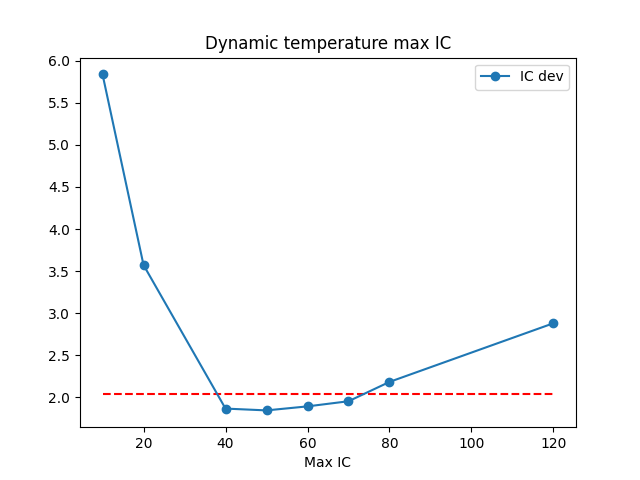

In [37]:
filtered_copy = filtered.copy()
filtered_copy.index = filtered_copy.index.map(lambda x: json.loads(x[1])['dynamic_temperature_max_ic'])
filtered_copy.index = filtered_copy.index.map(lambda x: int(x) if x.is_integer() else x)
filtered_copy.index.name = 'Max IC'
filtered_copy = filtered_copy.sort_index()
filtered_copy = filtered_copy.loc[:, [('ic_dev', 'abs_mean')]]
filtered_copy.columns = ['IC dev']
fig, ax = plt.subplots()
filtered_copy.plot(title="Dynamic temperature max IC", style="-o", ax=ax)
ax.hlines(filtered_copy[filtered_copy.index.isna()].values[0,0], filtered_copy.index.min(), filtered_copy.index.max(), 'r', '--')
# fig.show()

filtered_copy.index = filtered_copy.index.map(lambda x: str(int(x)) if x.is_integer() else "-")
# filtered_copy['Max IC'] = filtered_copy.index.map(lambda x: str(int(x)) if x.is_integer() else "-")
# filtered_copy = filtered_copy.pivot(columns=['IC dev', 'Max IC'])
filtered_copy = filtered_copy.T
styler = filtered_copy.style.format(decimal='.', thousands=',', precision=2)
# styler.index.format(lambda x: str(int(x)) if x.is_integer() else "-")
# styler = styler.hide(axis=1)
styler.to_latex('out/tables/eval_temp.tex')


step,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.0,2.0
IC dev,2.84,2.14,2.07,2.08,2.01,2.29,2.36,2.48,2.56,3.03


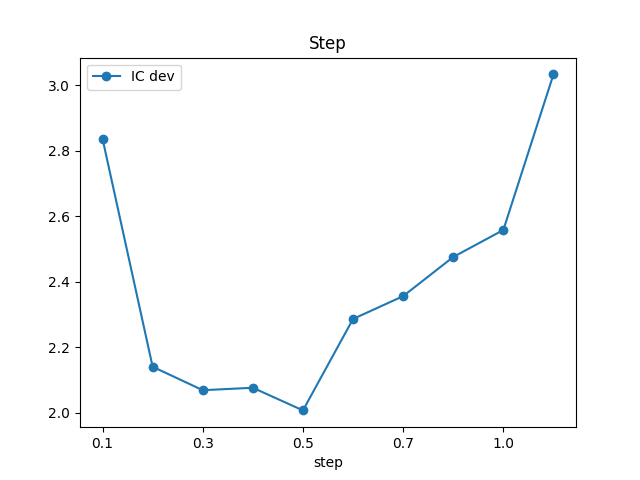

In [19]:
filtered = filter_pd(res_int, filter_steps)
filtered_copy = filtered.copy()
filtered_copy.index = filtered_copy.index.map(lambda x: json.loads(x[0])['time_points_generator']['step'])
filtered_copy.index = filtered_copy.index.map(lambda x: f"{x:.1f}")
filtered_copy.index.name = 'step'
filtered_copy = filtered_copy.sort_index()
filtered_copy = filtered_copy.loc[:, [('ic_dev', 'abs_mean')]]
filtered_copy.columns = ['IC dev']
fig, ax = plt.subplots()
filtered_copy.plot(title="Step", style="-o", ax=ax)
# ax.hlines(filtered_copy[filtered_copy.index.isna()].values[0,0], filtered_copy.index.min(), filtered_copy.index.max(), 'r', '--')
# fig.show()

# filtered_copy.index = filtered_copy.index.map(lambda x: str(int(x)) if x.is_integer() else "-")
# filtered_copy['Max IC'] = filtered_copy.index.map(lambda x: str(int(x)) if x.is_integer() else "-")
# filtered_copy = filtered_copy.pivot(columns=['IC dev', 'Max IC'])
filtered_copy = filtered_copy.T
styler = filtered_copy.style.format(decimal='.', thousands=',', precision=2)
# styler.index.format(lambda x: str(int(x)) if x.is_integer() else "-")
styler.to_latex('out/tables/eval_steps.tex')
styler


ic_dev  \
                                                                                                           mean   
exps                                               params                                                         
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 1, "temperature": 1.0, "n_poly_not...  0.695378   
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 128, "temperature": 1.0, "n_poly_n... -0.075088   
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 16, "temperature": 1.0, "n_poly_no...  0.349913   
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 2, "temperature": 1.0, "n_poly_not...  1.129652   
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 4, "temperature": 1.0, "n_poly_not...  0.795257   
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 64, "temperature": 1.0, "n_poly_no... -0.014529   

                                                                                                                 \
                                                                                                       abs_mean   
exps                                               params                                                         
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 1, "temperature": 1.0, "n_poly_not...  6.532444   
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 128, "temperature": 1.0, "n_poly_n...  1.218042   
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 16, "temperature": 1.0, "n_poly_no...  2.046516   
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 2, "temperature": 1.0, "n_poly_not...  4.658685   
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 4, "temperature": 1.0, "n_poly_not...  3.404863   
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 64, "temperature": 1.0, "n_poly_no...  1.432045   

                                                                                                                 \
                                                                                                            std   
exps                                               params                                                         
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 1, "temperature": 1.0, "n_poly_not...  9.536923   
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 128, "temperature": 1.0, "n_poly_n...  2.431556   
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 16, "temperature": 1.0, "n_poly_no...  3.696771   
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 2, "temperature": 1.0, "n_poly_not...  7.142391   
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 4, "temperature": 1.0, "n_poly_not...  5.641271   
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 64, "temperature": 1.0, "n_poly_no...  2.749431   

                                                                                                               
                                                                                                        count  
exps                                               params                                                      
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 1, "temperature": 1.0, "n_poly_not...   33880  
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 128, "temperature": 1.0, "n_poly_n...   33880  
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 16, "temperature": 1.0, "n_poly_no...  147390  
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 2, "temperature": 1.0, "n_poly_not...   33880  
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 4, "temperature": 1.0, "n_poly_not...   33880  
{"time_points_generator": {"step": 0.5, "eval_s... {"k_traces": 64, "temperature": 1.0, "n_poly_no...

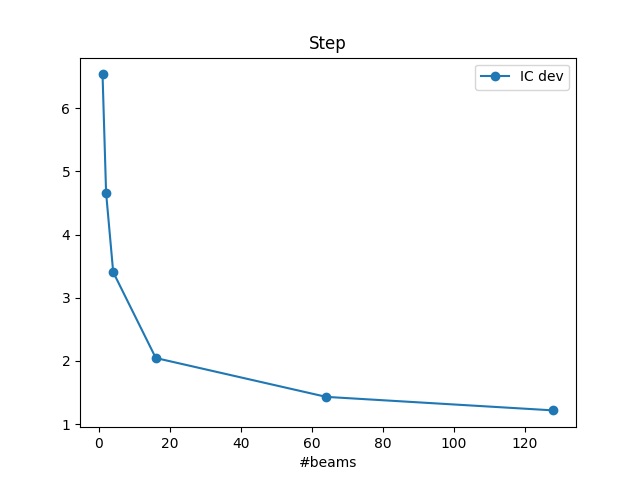

In [31]:
filtered = filter_pd(res_int, filter_k_traces)
filtered_copy = filtered.copy()
filtered_copy.index = filtered_copy.index.map(lambda x: int(json.loads(x[0])['time_points_generator']['k_traces']))
# filtered_copy.index = filtered_copy.index.map(lambda x: f"{x:.1f}")
filtered_copy.index.name = '#beams'
filtered_copy = filtered_copy.sort_index()
filtered_copy = filtered_copy.loc[:, [('ic_dev', 'abs_mean')]]
filtered_copy.columns = ['IC dev']
fig, ax = plt.subplots()
filtered_copy.plot(title="Step", style="-o", ax=ax)
# ax.hlines(filtered_copy[filtered_copy.index.isna()].values[0,0], filtered_copy.index.min(), filtered_copy.index.max(), 'r', '--')
# fig.show()

# filtered_copy.index = filtered_copy.index.map(lambda x: str(int(x)) if x.is_integer() else "-")
# filtered_copy['Max IC'] = filtered_copy.index.map(lambda x: str(int(x)) if x.is_integer() else "-")
# filtered_copy = filtered_copy.pivot(columns=['IC dev', 'Max IC'])
filtered_copy = filtered_copy.T
styler = filtered_copy.style.format(decimal='.', thousands=',', precision=2)
styler.to_latex('out/tables/eval_k_traces.tex')
filtered